## Notes

If it stalls around loss 60, you might need a smaller batch size, e.g. 8



## Log

### 20180506
Why is this not working? It stalls around loss=60 and just reconstructs the same mean image each time.

- batchnorm and pad? no lots of other models use them
    - https://github.com/josephsmann/UnsupervisedDeepLearning-Pytorch/blob/jm/udlp/autoencoder/convVAE.py#L19
    - https://github.com/taey16/pix2pixBEGAN.pytorch/blob/master/models/BEGAN.py
- relu, same
- lr - similar to other models
- inner params - similar but larger than other working models
- batch? Maybe it seems better with a lower batch (e.g. 8 instead of 32)
- loss, this seems right
    - except some people use a loss balance https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py#L97
        where they multuply reconstruction loss by 10 but i've got ~100 vs ~1e-4 so I don't really need to!
        
- ok a lower batch size seemed to get it over that initial hump

In [1]:
import os
os.sys.path.append('.')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from vae import VAE
from helpers.summarize import TorchSummarizeDf
from helpers.dataset import NumpyDataset, TQDMDaskProgressBar, load_npzs

In [5]:
l1loss = torch.nn.SmoothL1Loss()
def loss_function(recon_x, x, mu, logvar):
    logvar = logvar.clamp(1e-7)
    n, c, h, w = recon_x.size()
    recon_x = recon_x.view(n, -1)
    x = x.view(n, -1)
    # L2 distance
#     l2_dist = torch.sqrt(torch.sum(torch.pow(recon_x - x, 2), 1))
#     l2_dist = torch.sum(torch.pow(recon_x - x, 2), 1)
    l1smooth_dist = l1loss(recon_x, x)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
#     print(l2_dist, KLD)
    return torch.sum(l1smooth_dist*10000 + KLD)

In [6]:
env_name='sonic'
cuda= torch.cuda.is_available()
num_epochs=200
batch_size=32
data_cache_file = '/tmp/sonic_vae2.hdf5'

# Load data

In [7]:
# load as dask array

filenames = sorted(glob.glob('./data/vae/obs_data_' + env_name + '_*.npz'))

if not os.path.isfile(data_cache_file):
    data_train = load_npzs(filenames)
    print(data_train)
    with TQDMDaskProgressBar():
        da.to_hdf5(data_cache_file, '/x', data_train)
       
    # clear mem
    del data_train 
    import gc
    gc.collect()

In [8]:
# load
data = da.from_array(h5py.File(data_cache_file, mode='r')['x'], chunks=(200, 128, 128, 3))
data
data_split = int(len(data)*0.8)
data_train = data[:data_split]
data_test = data[data_split:]
data_train, data_test

(dask.array<getitem, shape=(96000, 128, 128, 3), dtype=float32, chunksize=(200, 128, 128, 3)>,
 dask.array<getitem, shape=(24000, 128, 128, 3), dtype=float32, chunksize=(200, 128, 128, 3)>)

In [9]:
   
dataset_train = NumpyDataset(data_train)
loader_train = torch.utils.data.DataLoader(dataset_train, pin_memory=True, shuffle=False, batch_size=batch_size)


dataset_test = NumpyDataset(data_test)
loader_test = torch.utils.data.DataLoader(dataset_test, pin_memory=True, shuffle=False, batch_size=batch_size)

dataset_train, loader_train

(<helpers.dataset.NumpyDataset at 0x7f337665c588>,
 <torch.utils.data.dataloader.DataLoader at 0x7f337665c470>)

# View model

In [23]:
vae = VAE(image_size=128, z_dim=32, conv_dim=64, code_dim=16, k_dim=256).cuda()

In [12]:
# # Resume?
state_dict = torch.load('./models/VAE_state_dict_2xv2l1.pkl')
vae.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: './models/VAE_state_dict_2xv2l1.pkl'

In [24]:
img = np.random.randn(64*2, 64*2, 3)
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()

with TorchSummarizeDf(vae) as tdf:
    x, mu, logvar = vae.forward(gpu_img)
    print(x.size())
    print(loss_function(x, gpu_img, mu, logvar))
    x = x.data.cpu().numpy()[0].transpose(1, 2, 0)
    df = tdf.make_df()
df

torch.Size([1, 3, 128, 128])
tensor(5092.3765, device='cuda:0')
Total parameters 8945315
Total trainable parameters 8945315


,name,class_name,input_shape,output_shape,nb_params,level
1,encoder.0.conv,Conv2d,"[[(-1, 3, 128, 128)]]","[[(-1, 64, 128, 128)]]",1792,2
2,encoder.0.bn,BatchNorm2d,"[[(-1, 64, 128, 128)]]","[[(-1, 64, 128, 128)]]",128,2
3,encoder.0.act,ReLU,"[[(-1, 64, 128, 128)]]","[[(-1, 64, 128, 128)]]",0,2
4,encoder.0,ConvBlock,"[[(-1, 3, 128, 128)]]","[[(-1, 64, 128, 128)]]",1920,1
5,encoder.1.conv,Conv2d,"[[(-1, 64, 128, 128)]]","[[(-1, 128, 64, 64)]]",131200,2
6,encoder.1.bn,BatchNorm2d,"[[(-1, 128, 64, 64)]]","[[(-1, 128, 64, 64)]]",256,2
7,encoder.1.act,ReLU,"[[(-1, 128, 64, 64)]]","[[(-1, 128, 64, 64)]]",0,2
8,encoder.1,ConvBlock,"[[(-1, 64, 128, 128)]]","[[(-1, 128, 64, 64)]]",131456,1
9,encoder.2.conv,Conv2d,"[[(-1, 128, 64, 64)]]","[[(-1, 192, 32, 32)]]",393408,2
10,encoder.2.bn,BatchNorm2d,"[[(-1, 192, 32, 32)]]","[[(-1, 192, 32, 32)]]",384,2


## Train

In [25]:
import collections

def train(loader, net, optimizer, loss_function, test=False, cuda=True):
    if test:
        net.eval()
    else:
        net.train()
    info = collections.defaultdict(list)
    
    with tqdm(total=len(loader)*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i, (batch,) in enumerate(loader):
            x = Variable(batch.transpose(1,3)).cuda() #*255 # FIXME (I divided by 255 once too many during gathering)
            y, mu, logvar = vae.forward(x)
            loss = loss_function(y, x, mu, logvar)
            info['loss'].append(loss.cpu().data.numpy())
            
            if not test:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            prog.update(loader.batch_size)
            prog.desc='loss={:2.4f}'.format(np.mean(info['loss']))
            
#             if i%(200000//batch_size)==0:
#                 print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'][-300:])))
        print('[{}/{}] loss={:2.4f}'.format(i, len(loader), np.mean(info['loss'])))
        prog.close()
    return info

In [ ]:
# Plot reconstructions
def plot_results(loader=loader_test, n=2, epoch=0):
    x, = next(iter(loader))

    X = Variable(x).cuda().transpose(1,3).contiguous()
    Y, mu, logvar = vae.forward(X)
    loss = loss_function(Y, X, mu, logvar)

    y=Y.cpu().data.transpose(1,3).numpy()
    for i in range(n):
        plt.subplot(1, 2, 1)
        plt.title('original')
        plt.imshow(x[i].numpy())

        plt.subplot(1, 2, 2)
        plt.imshow(y[i])
        plt.title('reconstructed')

        plt.suptitle('epoch {}, index {}, loss {:2.4f}'.format(epoch, i, loss.cpu().data.numpy()))
        plt.show()
        
# plot_results(loader=loader_test, n=2, epoch=epoch)

In [ ]:
# Train

optimizer = optim.Adam(vae.parameters(), lr=1e-4)
import torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [ ]:
infos=[]

In [ ]:
for epoch in range(num_epochs): 
    info = train(loader_train, vae, optimizer, loss_function, test=False, cuda=True)
    info_val = train(loader_test, vae, optimizer, loss_function, test=True, cuda=True)
    scheduler.step(np.mean(info_val['loss']))
    
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}'.format(epoch, np.mean(info['loss']), np.mean(info_val['loss'])))
    infos.append([info, info_val])
    
    plot_results(loader=loader_test, n=2, epoch=epoch)
    
    torch.save(vae.state_dict(), './models/VAE_{}_state_dict_2xv2l1.pkl'.format(epoch))

In [ ]:
loss=7032.0747: 9
loss=3677.535
3608
3500

In [ ]:
# try to get below 47-50 else go load last, and use lower learnign rate
# also think if I need more latent channels?
# try leaving overnight
# maybe I need a lower batch? lower than 6

In [ ]:
torch.save(vae, './models/VAE_2xv2l1.pkl')
torch.save(vae.state_dict(), './models/_state_dict_2xv2l1.pkl')

In [ ]:
# plot history
# mutliple first 11 epochs by 10k since I changes the loss
import pandas as pd
histories = []
for i, (info, info_val) in enumerate(infos):
    n = 1e4 if i<12 else 1
    history = {k+'_val':np.mean(v)*n for k,v in info_val.items()}
    history.update({k:np.mean(v)*n for k,v in info.items()})
    histories.append(history)
histories = pd.DataFrame(histories)
histories.plot()

In [ ]:
# def loss_function(recon_x, x, mu, logvar):
#     logvar = logvar.clamp(1e-7)
#     n, c, h, w = recon_x.size()
#     recon_x = recon_x.view(n, -1)
#     x = x.view(n, -1)
#     # L2 distance
# #     l2_dist = torch.sqrt(torch.sum(torch.pow(recon_x - x, 2), 1))
#     l2_dist = torch.sum(torch.pow(recon_x - x, 2), 1)
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1)
# #     print(l2_dist, KLD)
#     return torch.sum(l2_dist + KLD)

# x, = next(iter(loader_train))

# X = Variable(x).cuda().transpose(1,3).contiguous()
# Y, mu, logvar = vae.forward(X)
# # loss = loss_function(Y, X, mu, logvar)
# loss_function(Y, X, mu, logvar)

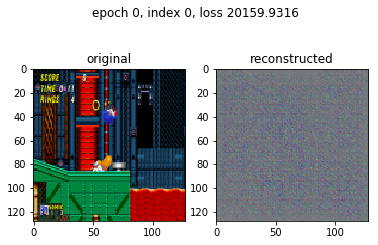

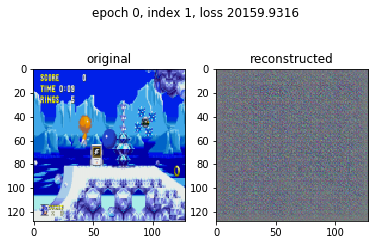

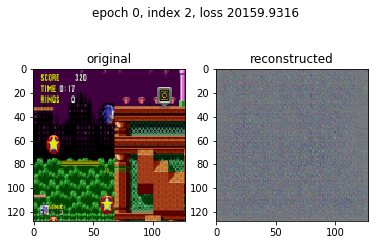

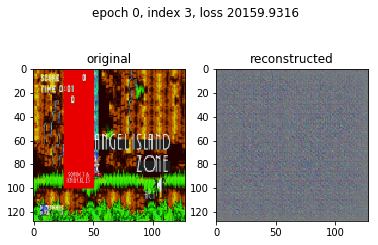

In [17]:
plot_results(loader=loader_test, n=4, epoch=0)

In [ ]:
plot_results(loader=loader_train, n=2, epoch=0)

# End

In [ ]:
1